# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numba import njit
from functools import partial

np.set_printoptions(suppress=True)

In [3]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

## Generative Model Definition

The movement of any agent $a = 1, ..., A$ is both related to: 1) its interaction with surrounding neighbors $i = 1, ..., I$, which we call *internal influence*, and 2) their motivation to the surrounding spatial objects $b = 1, ..., B$, which we call *external influence*. These influences are modulated by a stationary weight, $w_a$:

\begin{equation}
    \theta_{a, t} = w_a \theta_{a|j, t} + (1 - w_a) \theta_{a|i, t}.
\end{equation}

### Meta-Variables

First, we define some meta-variables, such as the number of agents to simulate, the number of spatial beacons present in the environment, etc.

In [4]:
num_agents = 12
num_beacons = 2
room_size = (8., 10.)
world_size = 25.

### Agent Initialization

First, we initialize the agents with a randomized position and orientation, both uniformly distributed.

In [5]:
@njit
def initialize_agents(
    num_agents: int = 12, 
    room_size: tuple = (8., 10.),
):
    """
    Generate random positions and orientations for agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100.0).

    Returns
    -------
    tuple of np.ndarray
        A tuple containing the positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    # Generate random positions within the boundary size centered at 0
    x = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[0]
    y = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[1]
    positions = np.vstack((x, y)).T
    
    # Generate random orientations (angles in radians between 0 and 2*pi)
    rotations = np.random.random(size=(num_agents, )).astype(np.float32) * np.pi * 2
    
    return positions.astype(np.float32), rotations.astype(np.float32)

In [41]:
agent_positions, agent_rotations = initialize_agents(room_size=room_size, num_agents=12)
agent_positions

array([[ 1.914329  , -4.0810757 ],
       [ 2.7776794 , -4.6193666 ],
       [-1.1429393 ,  4.628768  ],
       [ 0.62678766,  0.5162394 ],
       [-2.196447  ,  0.39975882],
       [-1.0867603 ,  4.7470617 ],
       [-3.5904198 , -0.12409925],
       [-1.7630785 , -2.9802778 ],
       [ 0.27422237,  3.0289836 ],
       [ 2.2916098 ,  3.3616643 ],
       [-1.5417924 , -2.727746  ],
       [ 2.5667815 ,  1.4605582 ]], dtype=float32)

### Beacon initialization

To intrinsically motivate the agents, we need a set of virtual beacons that are populated within the environment. The beacons have a freer representation with only positions needed.

In [8]:
@njit
def initialize_beacons(
        num_beacons = 10,
        room_sensing_range = 50.
):
    
    """
    Initialize beacons following a uniform distribution scaled to the room's sensing boundary
    
    Parameters
    ----------
    num_beacons : int, default: 10
        Number of beacons to initialize.
    room_sensing_range : float, default: 50.0
        Sensing distance of the room for the beacons to matter.
    
    Returns 
    -------
    beacons      : np.ndarray of shape (num_beacons, 2)
        Initial positions of the beacons. 
    """
    
    beacons = (np.random.random(size=(num_beacons, 2)) - 0.5) * room_sensing_range
    return beacons.astype(np.float32)

In [9]:
beacon_positions = initialize_beacons(num_beacons=1, room_sensing_range=world_size)
beacon_positions

array([[-9.868284 , -1.5674328]], dtype=float32)

## External Influence: drift-diffusion vector

We want to compute the influence of agent movement direction within a single time step. For this, we specify our internal influence as a 2D drift diffusion model, where the agents are approach a spatial beacon within the room's boundary by reorienting its locomotive direction.

\begin{equation}
    \theta_{a|j, t} = \theta_{a|j, t-1} + \omega_a \mathrm{d}t + \mathrm{d}\phi_t,
\end{equation}

\begin{align}
    \mathrm{d}\mathbf{x}_{a|j, t} 
    &= v_{a|j}\mathrm{d}t \frac{\mathbf{x}_{a|j}}{||\mathbf{x}_{a|j}||} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t \\
    &= v_{a}\mathrm{d}t     
    \begin{bmatrix}
        \cos \theta_{a|j, t} \\
        \sin \theta_{a|j, t}
    \end{bmatrix} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t,% \sqrt{\mathrm{d}t} Z_t.
\end{align}

In [51]:
@njit
def external_influence( 
    agent_position,
    beacon_position,
    noise = False,
    noise_amplitude = 0.01
):
    """
    Generate a drift-diffusion vector in 2D space for a single agent 
    based on a target location (in this case, the position of a beacon).

    Parameters
    ----------
    agent_position : np.ndarray
        The position of the agent.
    target_position : np.ndarray
        The position of the target beacon.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D vector representing the drift-diffusion process towards the target (beacon).
    """
    # Calculate the angle towards the beacon (in radian)
    beacon_direction = np.arctan2(
        beacon_position[1] - agent_position[1], 
        beacon_position[0] - agent_position[0]
    )
    
    # Generate a random direction with drift around the target angle
    if noise:
        beacon_direction = beacon_direction + (np.random.random() - 0.5) * noise_amplitude
        # beacon_direction = beacon_direction + np.random.vonmises(0., 8.) * noise_amplitude
    
    # Convert the angle to a unit vector in 2D space
    v = np.array([np.cos(beacon_direction), np.sin(beacon_direction)], dtype=np.float32)
    
    return v

Text(0, 0.5, 'y')

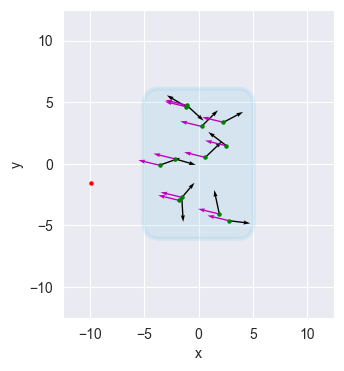

In [44]:
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(1, 1, figsize=(3.5, 4))

# Create a rounded rectangle with translucent face color
rounded_rect = FancyBboxPatch(
    (-5, -6),       # Lower left corner
    width=10.,        # Width
    height=12.,       # Height
    boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
    edgecolor=(0.53, 0.81, 0.92, 1),
    facecolor=(0.53, 0.81, 0.92, 0.2),
    linewidth=3,
    alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
)

ax.add_patch(rounded_rect)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    np.cos(agent_rotations), np.sin(agent_rotations), 
    angles='xy', scale_units="xy", 
    scale=0.5, width=0.005
)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    ve[0], ve[1], 
    angles='xy', scale_units="xy", 
    scale=0.5, width=0.005, color='m'
)
ax.scatter(agent_positions[:, 0], agent_positions[:, 1], c='g', s=5)
ax.scatter(beacon_positions[:, 0], beacon_positions[:, 1], c='r', s=5)
ax.set_xlim([-0.5 * world_size, 0.5 * world_size])
ax.set_ylim([-0.5 * world_size, 0.5 * world_size])
ax.set_xlabel('x')
ax.set_ylabel('y')

In [35]:
def move(agent_position, beacon_direction, dt = 0.1, v = 1., timesteps=100):
    
    from matplotlib.animation import FuncAnimation
    
    for i in range(timesteps):
        agent_position = agent_position + v * dt * beacon_direction

In [ ]:
beacon_direction = ve


## Internal Influence: particle dynamics

Its influence by a collective group of agents is modeled as a self-propelling particle system, as expressed in the Vicsek model:

\begin{align}
    \theta_{a|i, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a|i,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|i, t} \\
        \sin \theta_{a|i, t}
    \end{bmatrix},
\end{align}

In [108]:
@njit 
def internal_influence(
        self_position,
        other_positions,
        other_rotations,
        sensing_radius = 1.5,
        focus = 8.,
        noise = False
):
    """
    Generate an influence vector for a single agent 
    based on the angular component of the Vicsek model.

    Parameters
    ----------
    self_position : np.ndarray of shape (2,)
        A 2D vector representing the position of the agent
    other_positions : np.ndarray of shape (2,)
        A 2D vector representing the positions of the neighboring agents.
    other_rotations : np.ndarray of shape (2,)
        A 2D vector representing the rotations of the neighboring agents.
    sensing_radius : float
        The sensing radius within which agents interact with their neighbors.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D unit vector representing the averaged influence direction with added noise.
    """
      
    neighbor_rotations = []
    
    for i in range(len(other_positions)):
        dx = other_positions[i, 0] - self_position[0]
        dy = other_positions[i, 1] - self_position[1]
        d = (dx ** 2 + dy ** 2) ** 0.5
        
        if d <= sensing_radius and d > 0:
            neighbor_rotations.append(other_rotations[i])
            
    if len(neighbor_rotations) == 0:
        return np.array([0.0, 0.0], dtype=np.float32)
    
    neighbor_rotations = np.array(neighbor_rotations)
    averaged_rotation = np.sum(neighbor_rotations) / len(neighbor_rotations)
    
    if noise:
        deviation = (np.random.random() - 0.5) / focus
    else:
        deviation = np.random.vonmises(mu=0., kappa=focus)
    direction = averaged_rotation + deviation
    
    v = np.array([np.cos(direction), np.sin(direction)], dtype=np.float32) 
    
    return v

## Putting everything together: combined influences

The combined influences allow us to update the agents' positions and rotations together.

In [109]:
@njit
def update_agents(
    agent_positions: np.ndarray = None, 
    agent_rotations: np.ndarray = None,
    beacon_positions: np.ndarray = None,
    velocity: float = 1.0, 
    sensing_radius: float = 2.5,
    dt: float = 0.1, 
    influence_weight: float = 0.5,
    external_focus: float = 8.,
    internal_focus: float = 8.
):
    """
    Update the positions and orientations of a single agent 
    based on velocity and influence vectors.

    Parameters
    ----------
    agent_positions : np.ndarray
        Current positions of the agents.
    agent_rotations : np.ndarray
        Current orientations of the agents.
    beacon_positions : np.ndarray
        Positions of the beacons.
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    sensing_radius : float, optional
        The sensing radius within which agents interact with their neighbors.
    dt : float, optional
        The time step for updating positions and orientations (default is 0.1).
    influence_weight : float, optional
        The weight of influence_vector1 in determining new orientations (default is 0.7).
    external_focus : float, optional
        Concentration of the agent's rotational noise influenced by the beacons
    internal_focus : float, optional
        Concentration of the agent's rotational noise influenced by the neighbors

    Returns
    -------
    tuple of np.ndarray
        Updated positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    assert (len(agent_positions) == len(agent_rotations))
    
    num_agents = agent_positions.shape[0]
    num_beacons = beacon_positions.shape[0]
    
    # Create new numpy arrays for the updated agent positions and rotations
    new_agent_positions = np.zeros((num_agents, 2))
    new_agent_rotations = np.zeros((num_agents, ))
    
    for i in range(num_agents):
        # Generate the ddm vector for the agent based on its closest beacon
        distance_to_beacon = []
        
        for b in range(num_beacons):
            bx = beacon_positions[b, 0] - agent_positions[i, 0]
            by = beacon_positions[b, 1] - agent_positions[i, 1]
            distance_to_beacon.append((bx * bx + by * by) ** 0.5)
        
        beacon_id = np.argmin(np.array(distance_to_beacon))
        
        ddm_vector = external_influence(
            agent_positions[i], 
            beacon_positions[beacon_id],
            focus=external_focus
        )
        
        # Generate the vicsek vector for the agent based on its neighbors (all agents)
        vicsek_vector = internal_influence(
            self_position=agent_positions[i],
            other_positions=agent_positions,
            other_rotations=agent_rotations,
            sensing_radius=sensing_radius,
            focus=internal_focus
        )

        # Update orientations based on two influence vectors
        ddm_influence = np.arctan2(ddm_vector[1], ddm_vector[0])
        vicsek_influence = np.arctan2(vicsek_vector[1], vicsek_vector[0])
        
        # Combine influences to update orientations with different weights
        new_agent_rotations[i] = agent_rotations[i] + (influence_weight * ddm_influence + (1 - influence_weight) * vicsek_influence) * dt
        
        # Ensure orientations are within the range [0, 2*pi]
        new_agent_rotations[i] = np.mod(new_agent_rotations[i], 2 * np.pi)
        
        # Update positions based on current orientations
        new_agent_positions[i, 0] = agent_positions[i, 0] + velocity * np.cos(new_agent_rotations[i].item()) * dt
        new_agent_positions[i, 1] = agent_positions[i, 1] + velocity * np.sin(new_agent_rotations[i].item()) * dt
    
    return new_agent_positions, new_agent_rotations

In [110]:
agent_positions, agent_rotations = initialize_agents(12, room_size=room_size)
beacon_positions = initialize_beacons(num_beacons=2)
new_agent_positions, new_agent_rotations = update_agents(agent_positions, agent_rotations, beacon_positions)

In [111]:
np.concatenate([agent_positions, new_agent_positions], axis=1)

array([[ 0.76936388, -3.43732738,  0.76312379, -3.33752227],
       [-0.54201984,  3.72437763, -0.55967931,  3.62594927],
       [-0.62435794,  1.36371076, -0.55429038,  1.29236276],
       [-0.11766601, -3.53486204, -0.01770987, -3.53782353],
       [ 3.19171762, -4.93764353,  3.09645593, -4.96806079],
       [-1.48790526, -4.01669645, -1.58364969, -3.98783461],
       [-2.96623182, -3.40603781, -2.91145982, -3.48970397],
       [ 1.66077423, -2.10265875,  1.59844927, -2.18086105],
       [-1.76497912, -3.76371336, -1.86084067, -3.79218376],
       [-3.76360106, -2.04679489, -3.69062664, -2.11516691],
       [ 2.47838259, -1.33208334,  2.50661288, -1.23615081],
       [-3.67530942, -4.51827717, -3.61037137, -4.59432353]])

In [112]:
np.vstack([agent_rotations, new_agent_rotations]).T

array([[1.56055701, 1.63323777],
       [4.67188883, 4.53486335],
       [5.69278193, 5.48873292],
       [6.25014496, 6.25356611],
       [3.60673714, 3.45066239],
       [3.09897304, 2.84880915],
       [5.48928738, 5.29202574],
       [4.314991  , 4.03949777],
       [3.33828592, 3.43029031],
       [5.39299011, 5.53033684],
       [1.49452567, 1.28460254],
       [5.63666582, 5.41915854]])

## Simulation Loop

The update allows us to continuously simulate the agents' positions and rotations at a given interval

In [113]:
@njit
def simulator_fun(
    theta = None,
    num_agents: int = 12, 
    num_beacons: int = 1,
    room_size: tuple = (8, 10),
    velocity: float = 1.0, 
    dt: float = 0.1, 
    influence_weight: float = 0.7, 
    sensing_radius: float = 10.0,
    internal_focus: float = 8.,
    external_focus: float = 8.,
    num_timesteps: int = 1000
):
    """
    Run the simulation and store the time series of positions and orientations of agents.

    Parameters
    ----------
    theta : np.ndarray
        Prior parameters specifying the internal properties of the agents
    num_agents : int, optional
        Number of agents to generate (default is 100).
    num_beacons : int, optional
        Number of beacons to generate (default is 1).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100).
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    dt : float, optional
        The time step for the update (default is 0.1).
    influence_weight : float, optional
        The weight for influence_vector1 in determining new orientations (default is 0.7).
    sensing_radius : float, optional
        The sensing radius for the Vicsek model (default is 10.0).
    num_timesteps : int, optional
        The number of steps to simulate (default is 100).

    Returns
    -------
    tuple of np.ndarray
        The time series of positions and orientations of the agents.
    """
    
    if theta is not None:
        influence_weight = theta[0]
        sensing_radius = theta[1]
        velocity = theta[2]
        external_focus = theta[3]
        internal_focus = theta[4]
    
    
    # Initialize positions and orientations
    initial_positions, initial_rotations = initialize_agents(num_agents, room_size=room_size)

    # Initialize arrays to store time series of positions and orientations
    positions = np.zeros((num_timesteps, num_agents, 2))
    rotations = np.zeros((num_timesteps, num_agents, ))
    positions[0] = initial_positions
    rotations[0] = initial_rotations
    
    # Initialize beacons
    beacon_positions = initialize_beacons(num_beacons)

    # Simulation loop
    for t in range(1, num_timesteps):
        ps, rs = update_agents(
            agent_positions=positions[t-1], 
            agent_rotations=rotations[t-1], 
            beacon_positions=beacon_positions, 
            velocity=velocity, 
            sensing_radius=sensing_radius, 
            dt=dt, 
            influence_weight=influence_weight,
            external_focus=external_focus,
            internal_focus=internal_focus
        )
        
        # Store positions and orientations for each time step
        positions[t] = ps
        rotations[t] = rs
    
    rotations = rotations[:,:,np.newaxis]

    return np.concatenate((positions, rotations), axis=-1)

In [217]:
out = simulator_fun(num_agents=12, num_beacons=2, influence_weight=0., num_timesteps=1001, internal_focus=1., external_focus=1.)
out.shape

(1001, 12, 3)

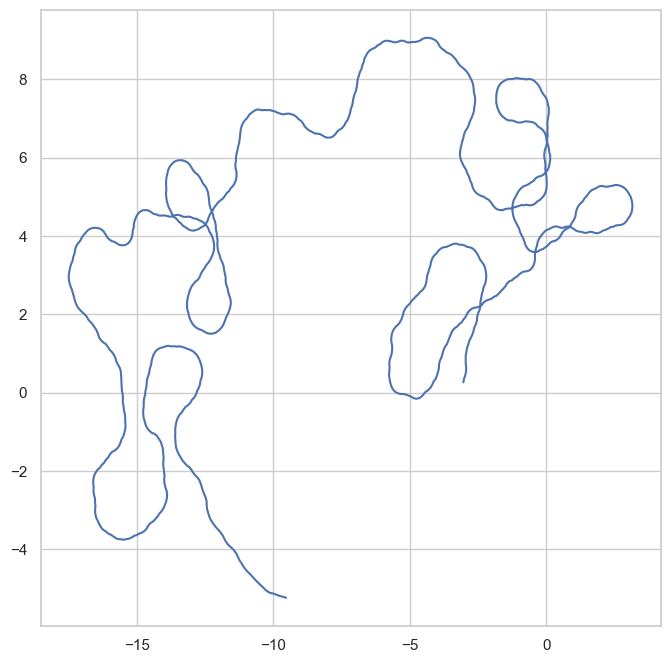

In [218]:
positions = out[:, :, 0:2]
rotations = out[:, :, -1]

f, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(positions[:,1,0], positions[:,1,1], c='b')

# Complete pooling priors

In [243]:
param_names = [
    r"$w$",
    r"$r$",
    r"$v$",
    # r"$\eta$",
    # r"$\kappa$"
]

In [244]:
@njit
def prior_fun():
    weight = np.random.beta(2, 2)
    radius = np.random.beta(2, 2) * 5.
    v = np.random.beta(2, 2) * 2.
    # internal_focus = np.random.random()
    # external_focus = np.random.random() * 4. + 4.
    return np.array([weight, radius, v]) #, internal_focus]) #, external_focus])

In [245]:
theta = prior_fun()
theta

array([0.66969716, 3.18679405, 1.12992399])

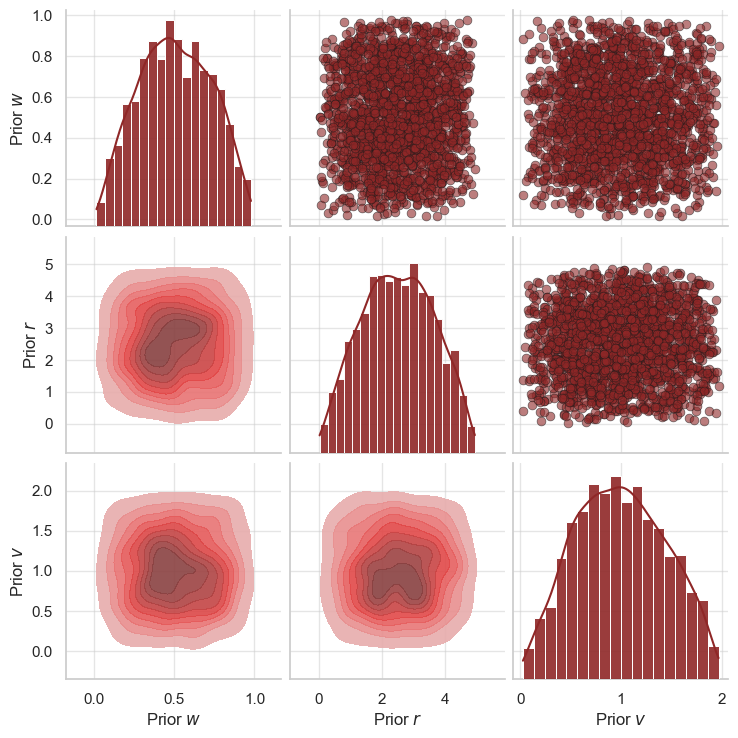

In [246]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)
pp_check = prior.plot_prior2d()

# Generative Model

In [247]:
simulator = Simulator(simulator_fun=partial(simulator_fun, num_timesteps=1001))
simulator

In [248]:
model = GenerativeModel(
    prior=prior,
    simulator=simulator,
    simulator_is_batched=False,
    name="TogetherFlow"
)

INFO:root:Performing 2 pilot runs with the TogetherFlow model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1001, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


### Prior Pushforward Check

In [249]:
out = model(1)
out['sim_data'][0,:,0].shape

(1001, 3)

# Configurator

In [250]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

# Neural Approximator

In [253]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)

amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)

# Training

In [254]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


### Offline Training

In [255]:
training_set = model(5000)

In [256]:
h = trainer.train_offline(training_set, epochs=30, batch_size=100, validation_sims=model(200))

Training epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.700


Training epoch 2:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 1.543


Training epoch 3:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 1.336


Training epoch 4:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 1.268


Training epoch 5:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 1.219


Training epoch 6:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 1.215


Training epoch 7:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 1.164


Training epoch 8:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 1.113


Training epoch 9:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 1.167


Training epoch 10:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 1.115


Training epoch 11:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 1.077


Training epoch 12:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 1.060


Training epoch 13:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 1.074


Training epoch 14:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 1.071


Training epoch 15:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 1.035


Training epoch 16:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 1.010


Training epoch 17:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 0.974


Training epoch 18:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 1.001


Training epoch 19:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 0.988


Training epoch 20:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 1.011


Training epoch 21:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 1.010


Training epoch 22:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 0.978


Training epoch 23:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 0.989


Training epoch 24:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 0.998


Training epoch 25:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 0.992


Training epoch 26:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 1.052


Training epoch 27:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 0.992


Training epoch 28:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 0.998


Training epoch 29:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 1.005


Training epoch 30:   0%|          | 0/50 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 1.001


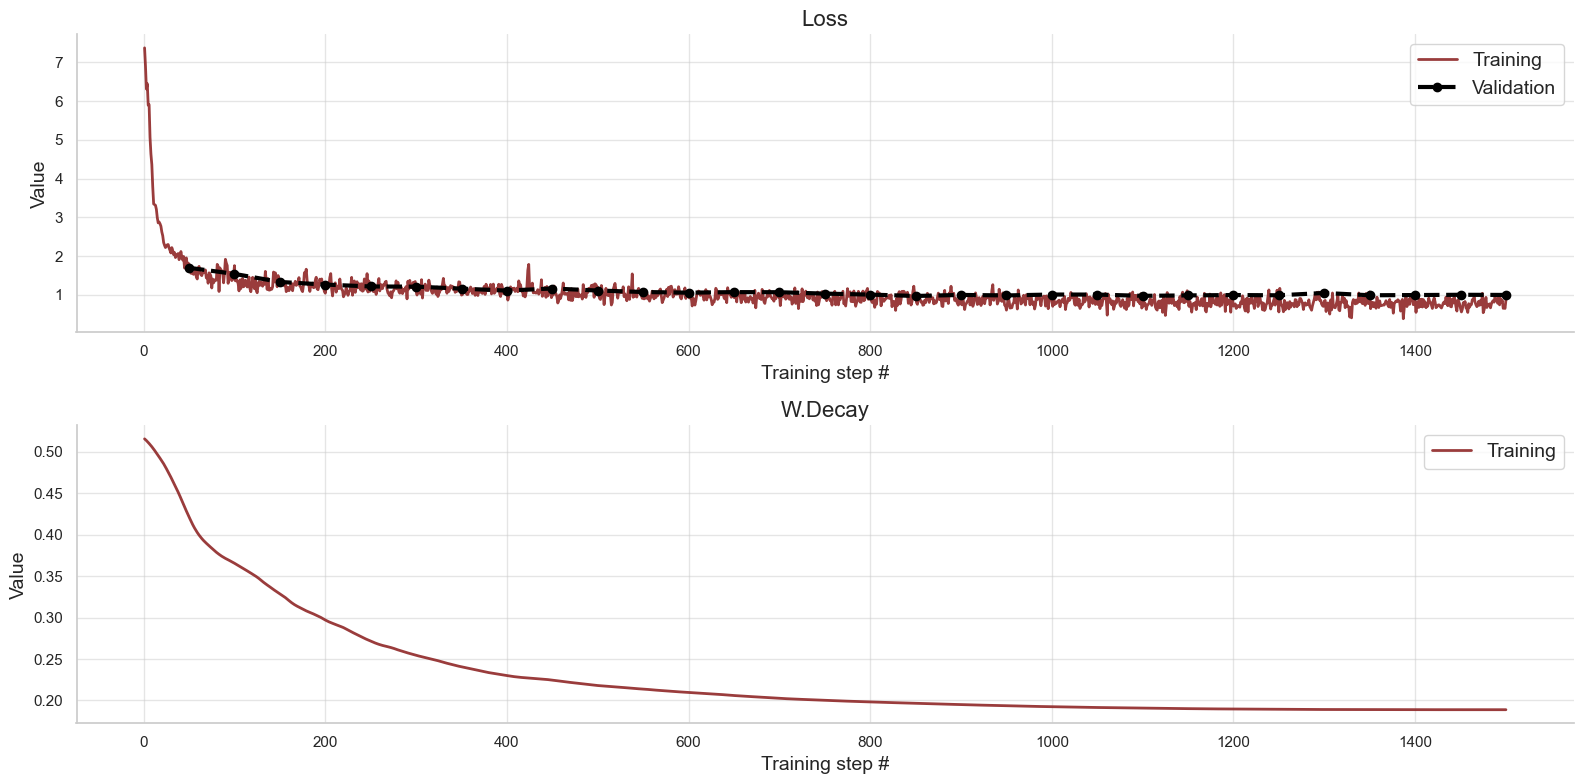

In [257]:
losses = bf.diagnostics.plot_losses(train_losses=h['train_losses'], val_losses=h['val_losses'])

In [258]:
val_sims = configurator(model(400))
post_dev_samples = amortizer.sample(val_sims, n_samples=500)
prior_dev_samples = val_sims['parameters']

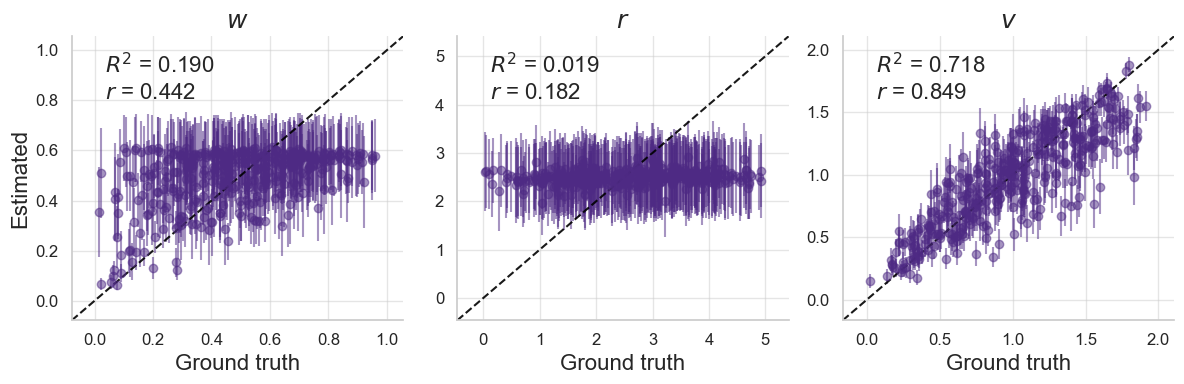

In [259]:
sns.set(rc={'axes.facecolor':'#FFFFFF00', 'figure.facecolor':'#FFFFFF00'})
sns.set_style('whitegrid')

g = bf.diagnostics.plot_recovery(
    post_samples=post_dev_samples, 
    prior_samples=prior_dev_samples, 
    param_names=param_names,
    color="#4E2A84"
)

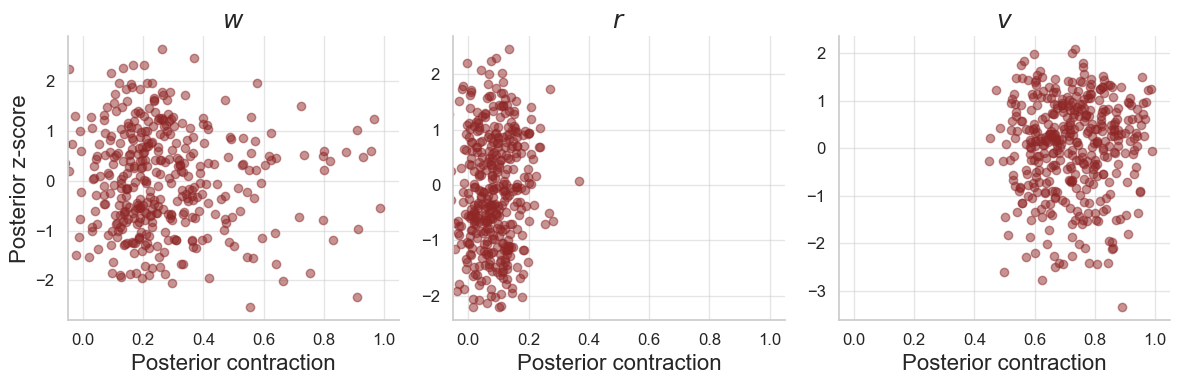

In [260]:
c = bf.diagnostics.plot_z_score_contraction(
    post_samples=post_dev_samples, 
    prior_samples=prior_dev_samples, 
    param_names=param_names
)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


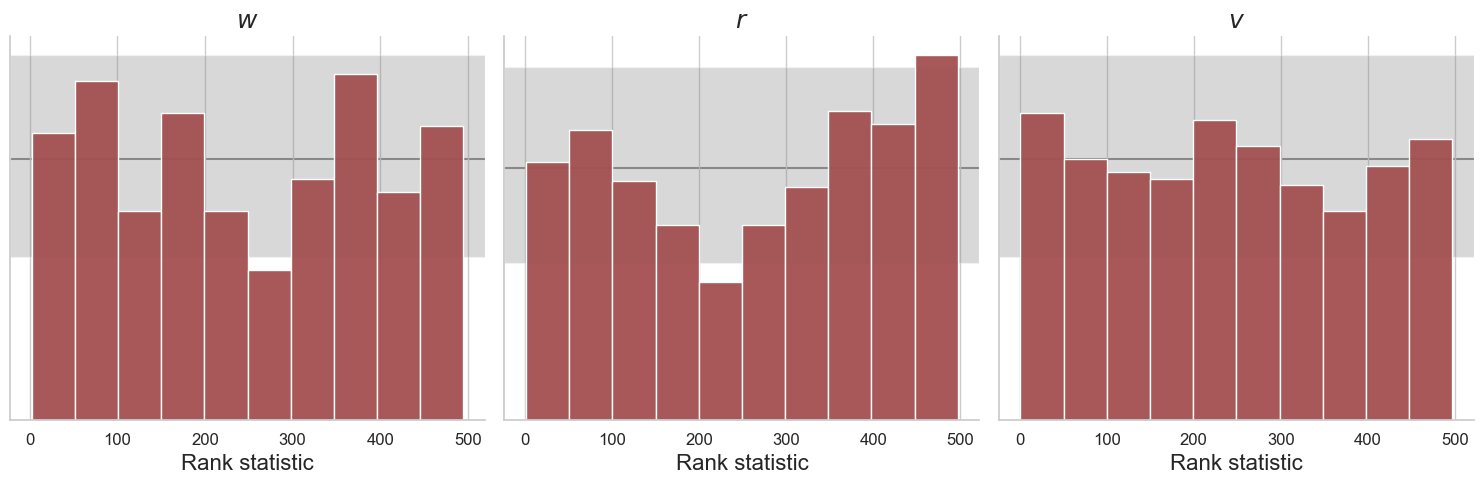

In [261]:
h = bf.diagnostics.plot_sbc_histograms(
    post_samples=post_dev_samples, 
    prior_samples=prior_dev_samples, 
    param_names=param_names, 
    num_bins=10
)

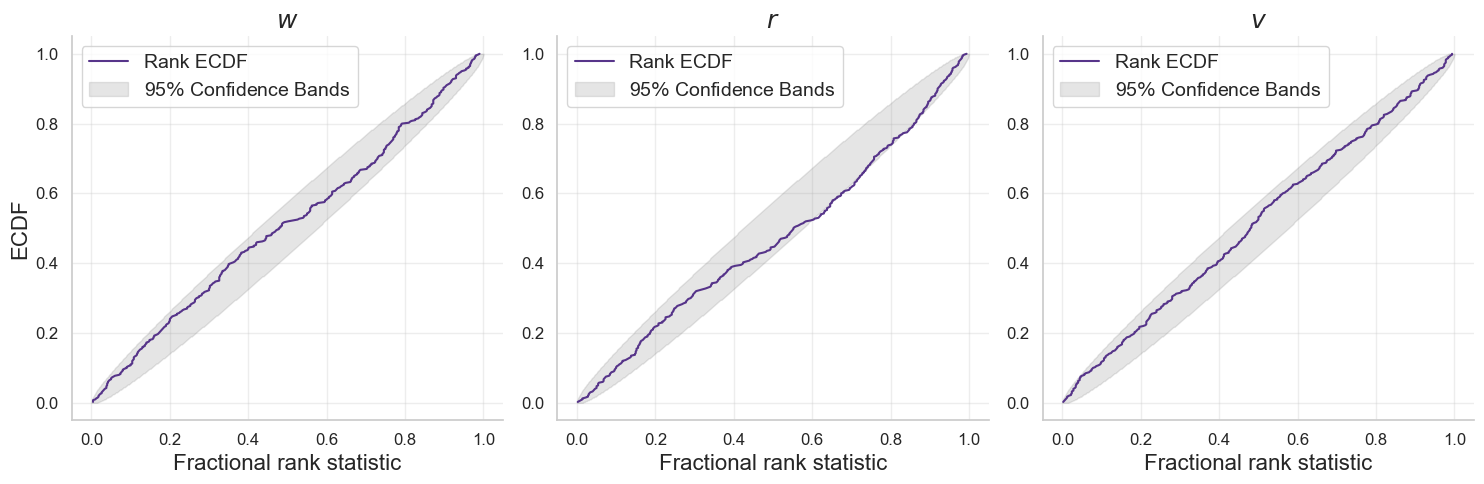

In [262]:
e = bf.diagnostics.plot_sbc_ecdf(
    post_samples=post_dev_samples, 
    prior_samples=prior_dev_samples, 
    param_names=param_names, 
    rank_ecdf_color="#4E2A84"
)

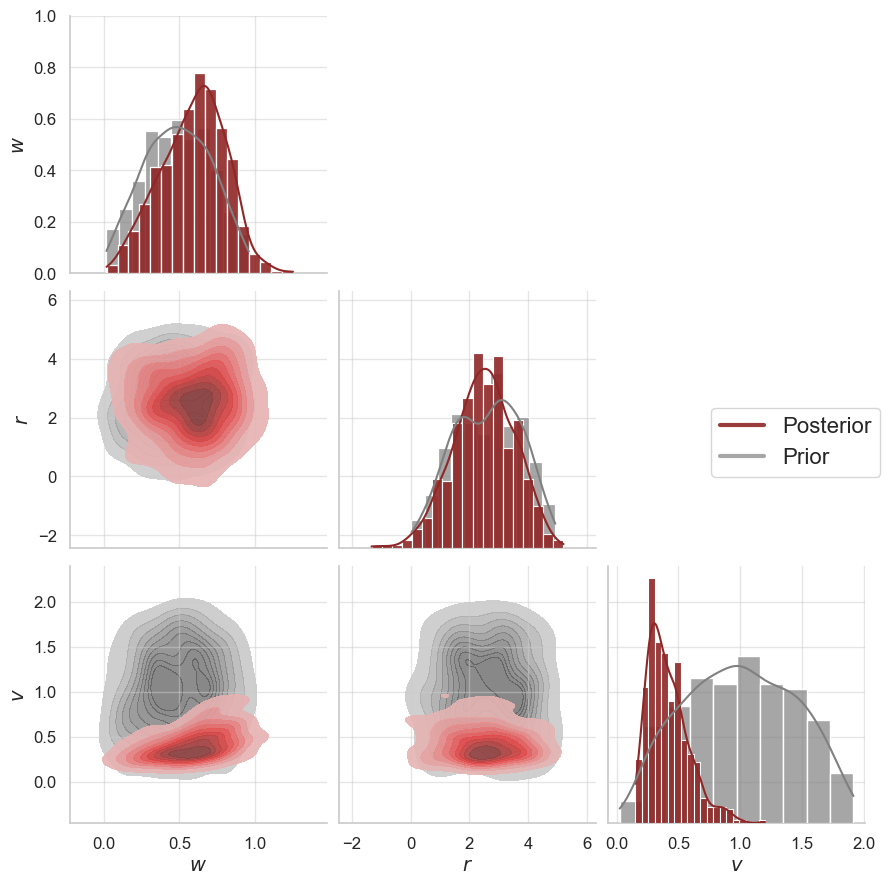

In [263]:
d = bf.diagnostics.plot_posterior_2d(
    posterior_draws=post_dev_samples[1], 
    prior_draws=prior_dev_samples, 
    param_names=param_names
)

### Online Training

In [463]:
history = trainer.train_online(epochs=1, batch_size=32, iterations_per_epoch=200)

Training epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

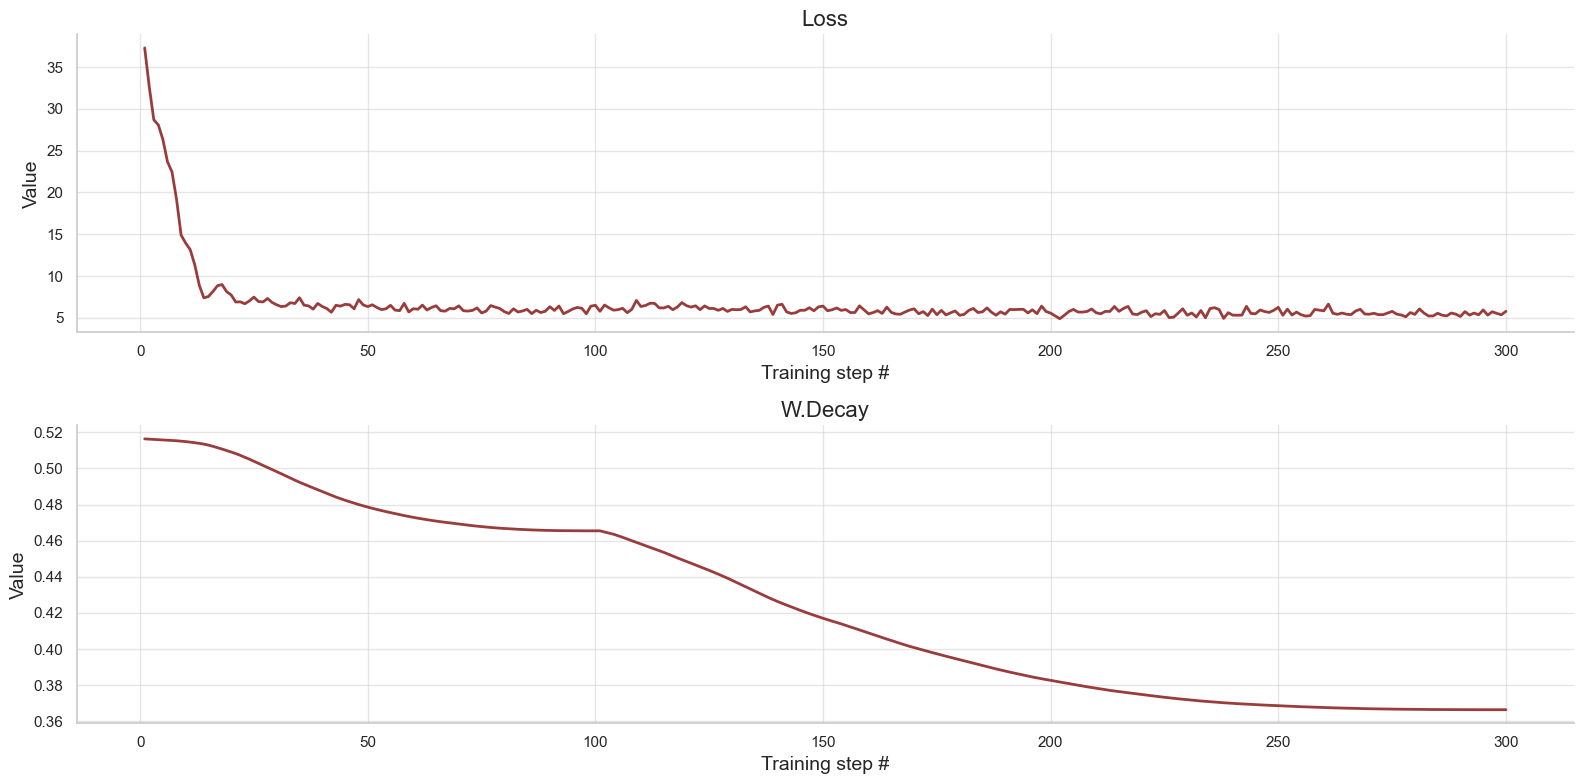

In [464]:
f = bf.diagnostics.plot_losses(history)

### Validation

In [465]:
validation_sim = model(400)
validation_configured = configurator(validation_sim)

In [466]:
validation_configured["parameters"]

array([[0.07457702, 2.2404974 , 0.32573527, 2.164974  , 4.5262146 ],
       [0.43720496, 0.82371724, 0.498905  , 3.9733164 , 4.486686  ],
       [0.19165172, 7.8879843 , 0.2869358 , 4.3568354 , 2.5753455 ],
       ...,
       [0.46955454, 2.6333323 , 0.6379486 , 2.6327906 , 5.824963  ],
       [0.44751653, 4.016421  , 0.37790635, 4.3941045 , 2.7543514 ],
       [0.16260357, 2.1308763 , 0.7748053 , 3.3457994 , 6.5417805 ]],
      dtype=float32)

In [467]:
post_samples = amortizer.sample(validation_configured, n_samples=1000)
prior_samples = validation_configured["parameters"]

# Parameter Recovery

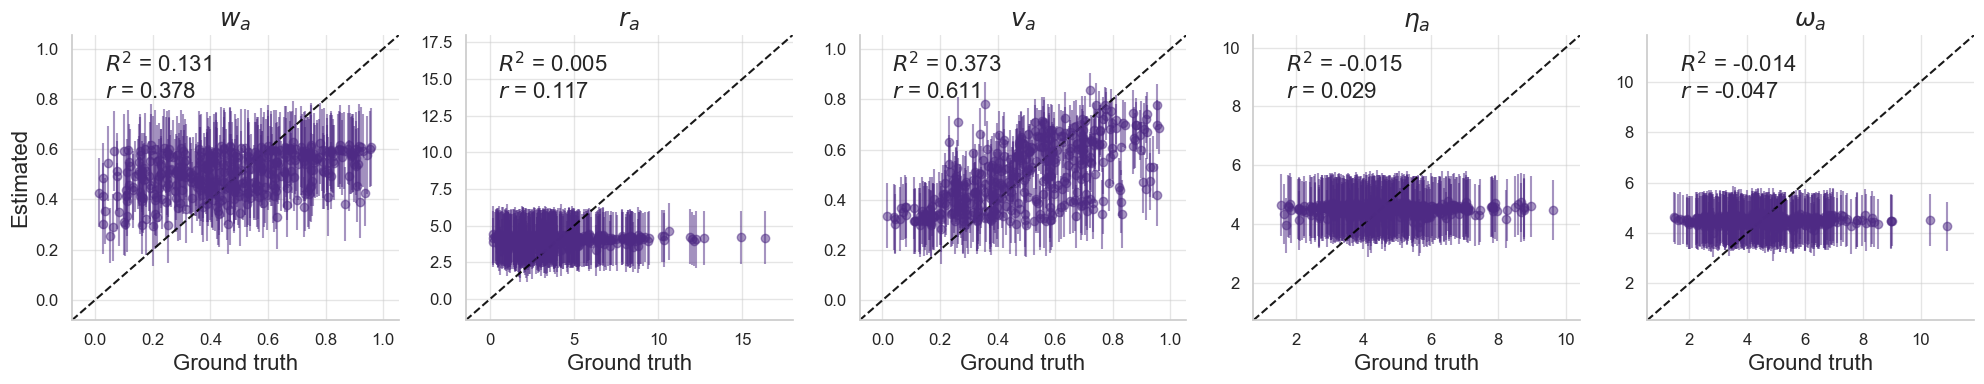

In [468]:
sns.set(rc={'axes.facecolor':'#FFFFFF00', 'figure.facecolor':'#FFFFFF00'})
sns.set_style('whitegrid')

g = bf.diagnostics.plot_recovery(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names,
    color="#4E2A84"
)

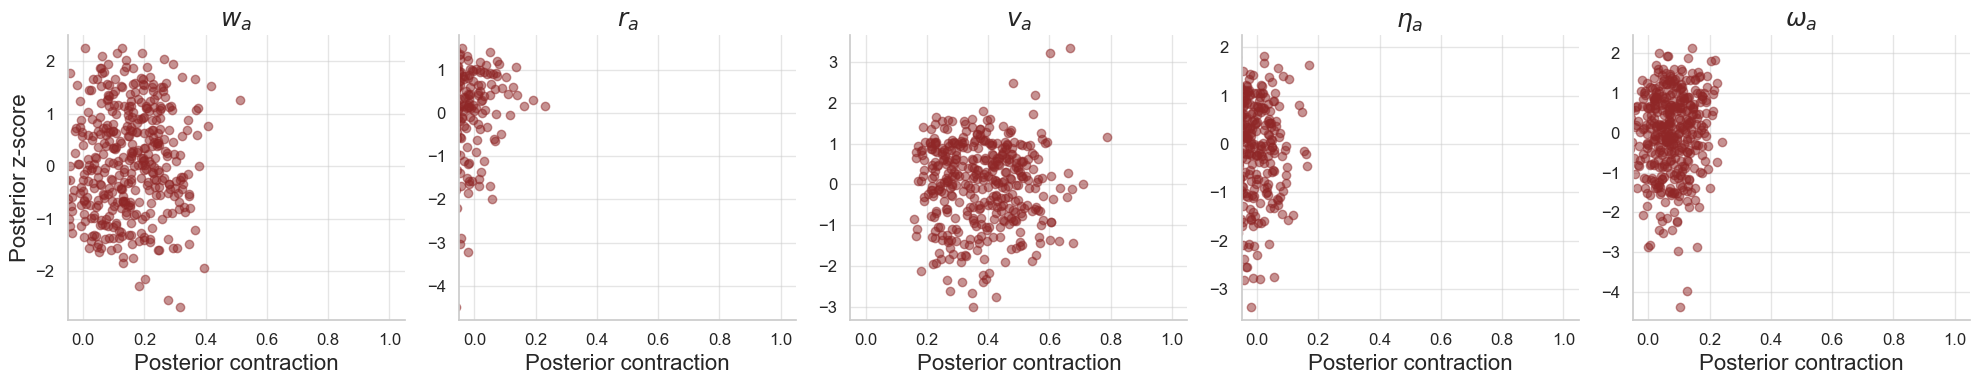

In [469]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

# SBC

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


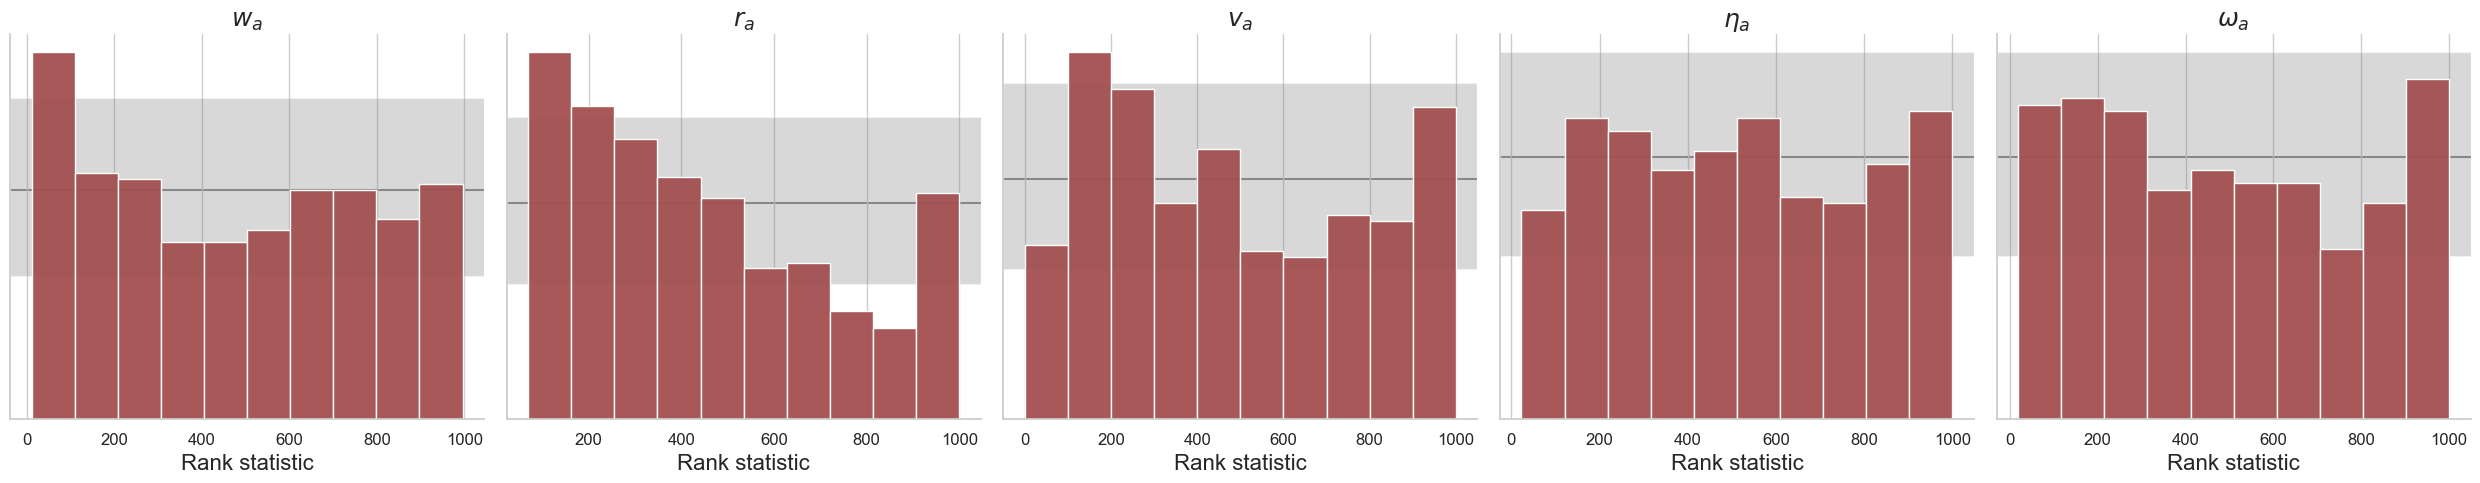

In [470]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

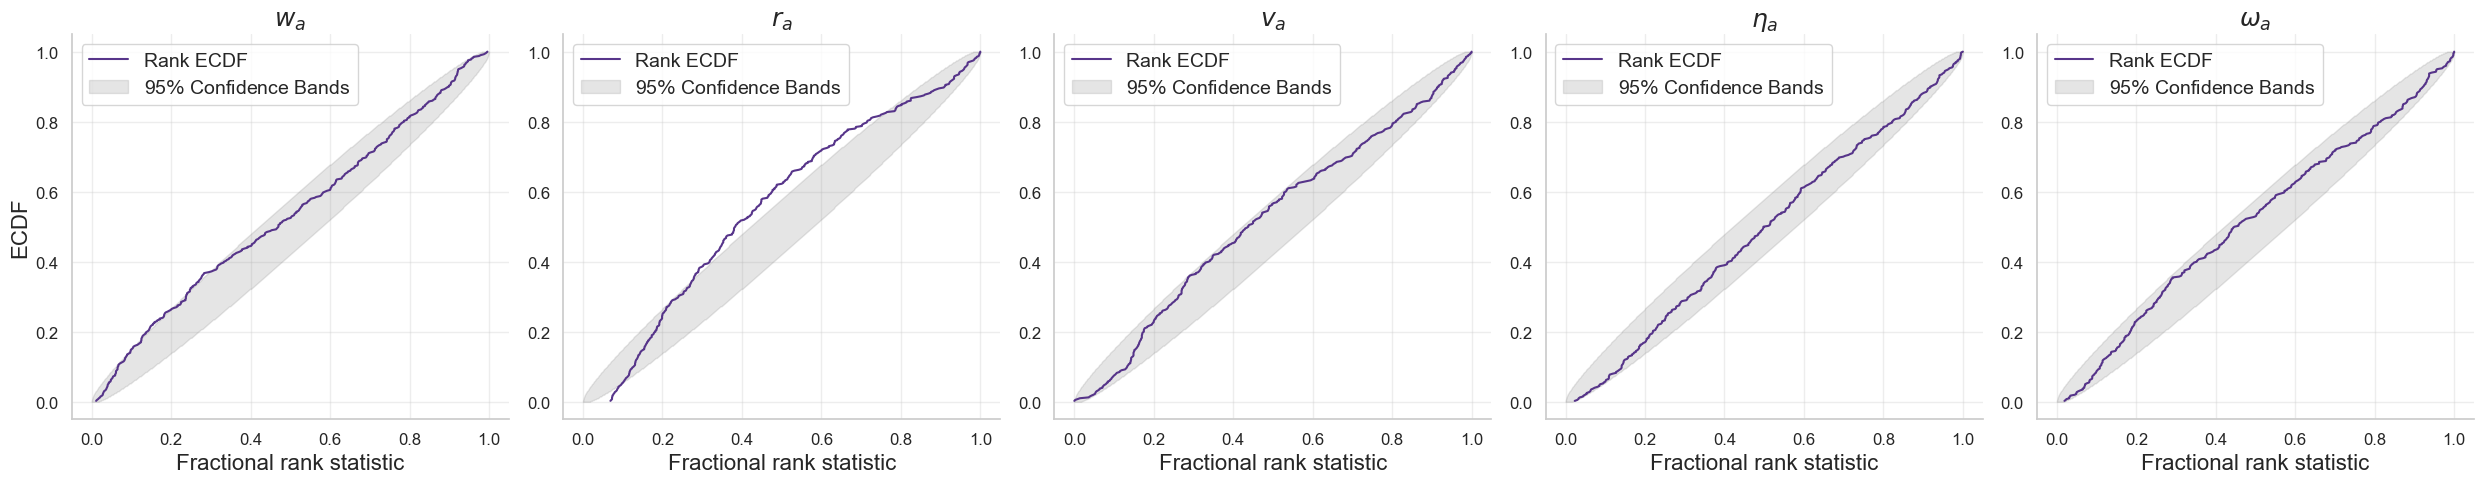

In [471]:
e = bf.diagnostics.plot_sbc_ecdf(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names, 
    rank_ecdf_color="#4E2A84"
)

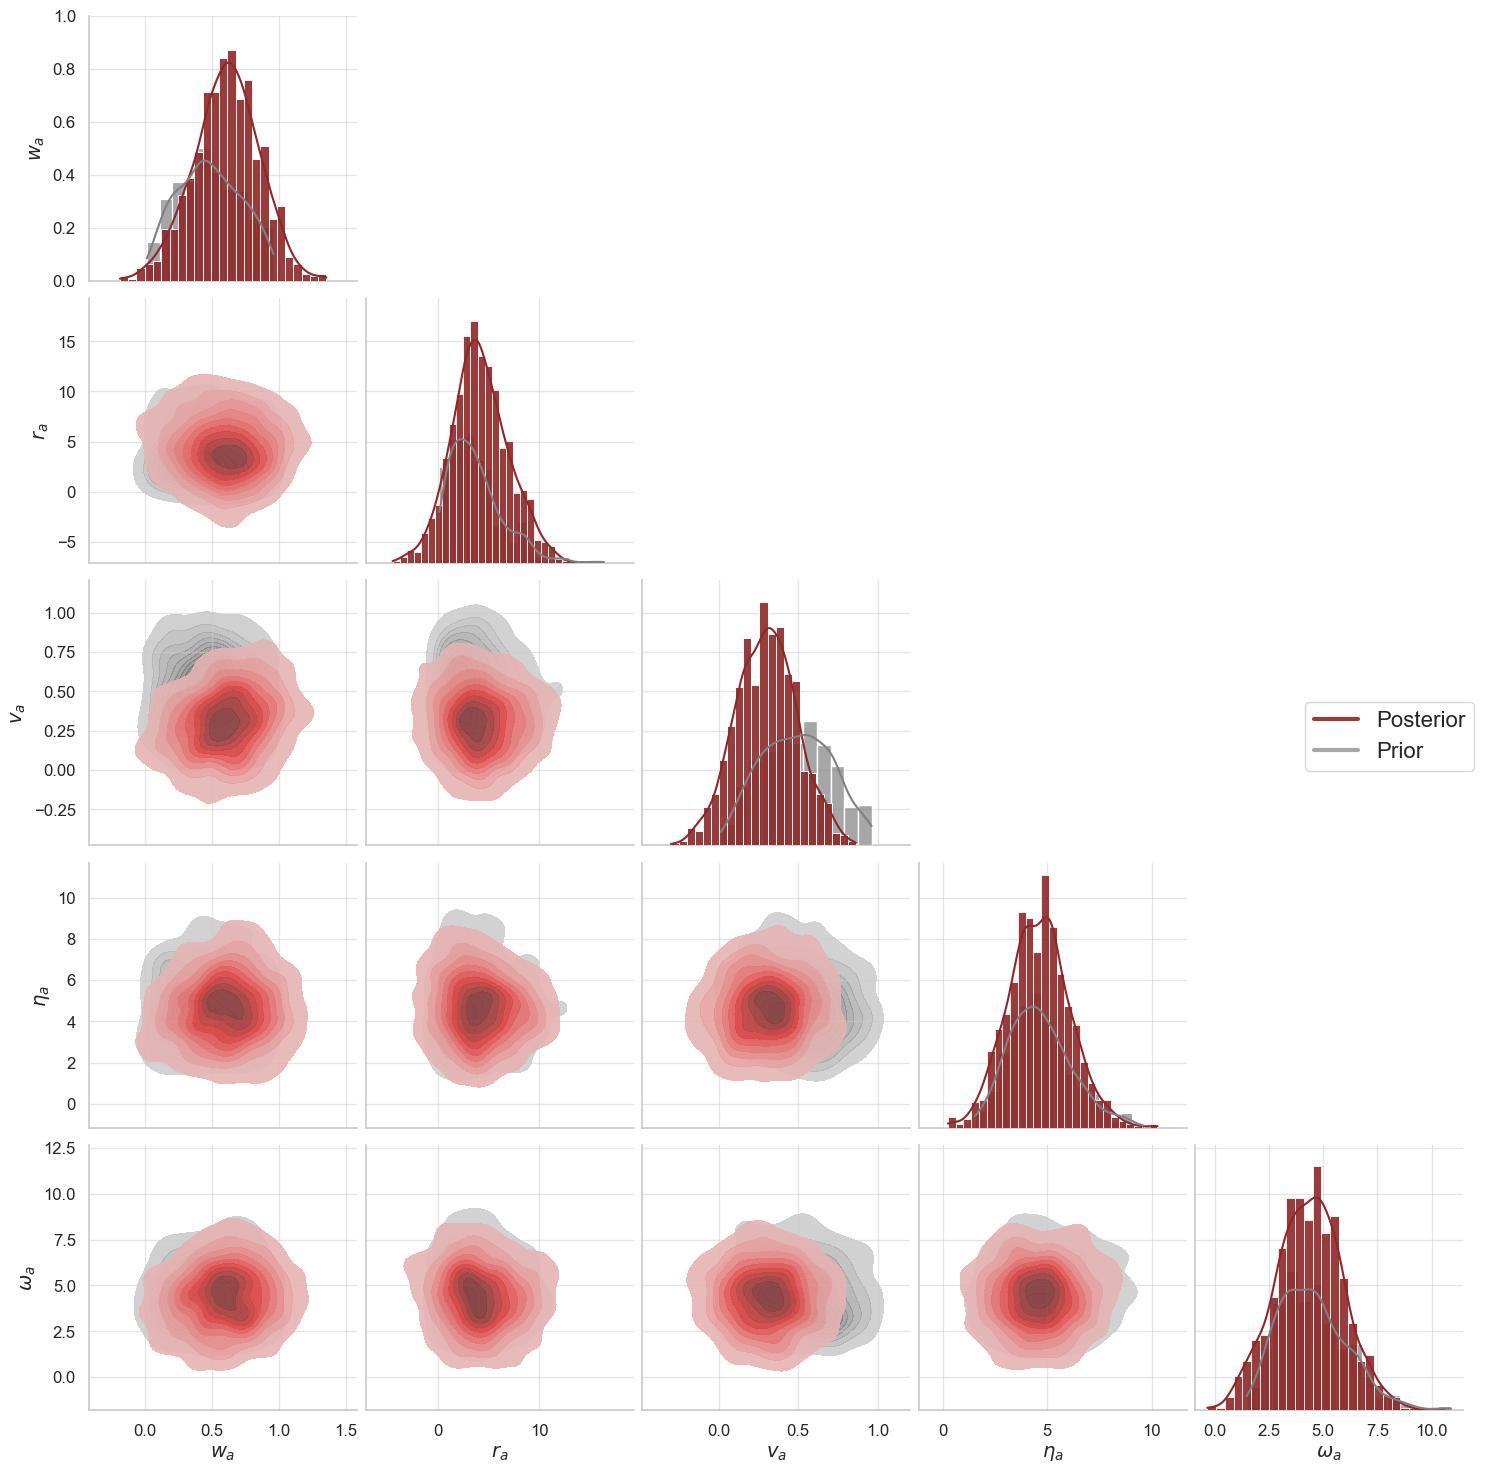

In [472]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior_draws=prior_samples, param_names=param_names)